## Cellposeを利用したsegmentation
ここでは、細胞核の画像をもとに、ざっくりとcellposeを利用して自動的にsegmentationさせる。
後で、人の目で補正していく。

最初に、以下の" "の間に、githubからダウンロードしたフォルダのパスを指定する。

In [1]:
import os

# 現在のディレクトリのパスを取得
current_directory = os.getcwd()
# 現在のディレクトリの2つ上の階層のパスを取得
dir = os.path.dirname(current_directory)
print(dir)

/Users/HiroshiOchiai/Downloads/seqFISH_analysis_test-main


以下では必要なモジュールをインポートする。

In [2]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300 #要変更？ https://analytics-note.xyz/programming/matplotlib-figsize-dpi/
from cellpose import utils, io
import napari
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects
from skimage.transform import rescale, resize, downscale_local_mean
from cellpose import models, io
import matplotlib.pyplot as plt
from cellpose import plot
import pyclesperanto_prototype as cle
from skimage.transform import rescale, resize, downscale_local_mean
from tifffile import imwrite

2023-12-26 11:40:48,781 [INFO] >>>> using CPU
2023-12-26 11:40:48,832 [INFO] ~~~ FINDING MASKS ~~~
2023-12-26 11:40:48,832 [INFO] multi-stack tiff read in as having 108 planes 1 channels
2023-12-26 11:40:48,954 [INFO] running YX: 108 planes of size (76, 70)
2023-12-26 11:40:54,769 [INFO] 100%|##########| 4/4 [00:05<00:00,  1.45s/it]
2023-12-26 11:40:54,789 [INFO] running ZY: 76 planes of size (108, 70)
2023-12-26 11:40:59,591 [INFO] 100%|##########| 3/3 [00:04<00:00,  1.60s/it]
2023-12-26 11:40:59,606 [INFO] running ZX: 70 planes of size (108, 76)
2023-12-26 11:41:05,708 [INFO] 100%|##########| 3/3 [00:06<00:00,  2.03s/it]
2023-12-26 11:41:05,725 [INFO] network run in 16.80s
2023-12-26 11:41:06,076 [INFO] masks created in 0.35s
2023-12-26 11:41:06,188 [INFO] >>>> TOTAL TIME 17.36 sec
Available OpenCL devices:['Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz', 'AMD Radeon Pro 5500 XT Compute Engine']
Available GPU OpenCL devices:['AMD Radeon Pro 5500 XT Compute Engine']
Available CPU OpenCL de

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Public-TS-873/Microscope/Ochiai/240301-seqFISH-MMB/231224-image_analysis_v3/1_processed_images/3_diveded_files/Pos04/ND31_C4_TyR.tif'

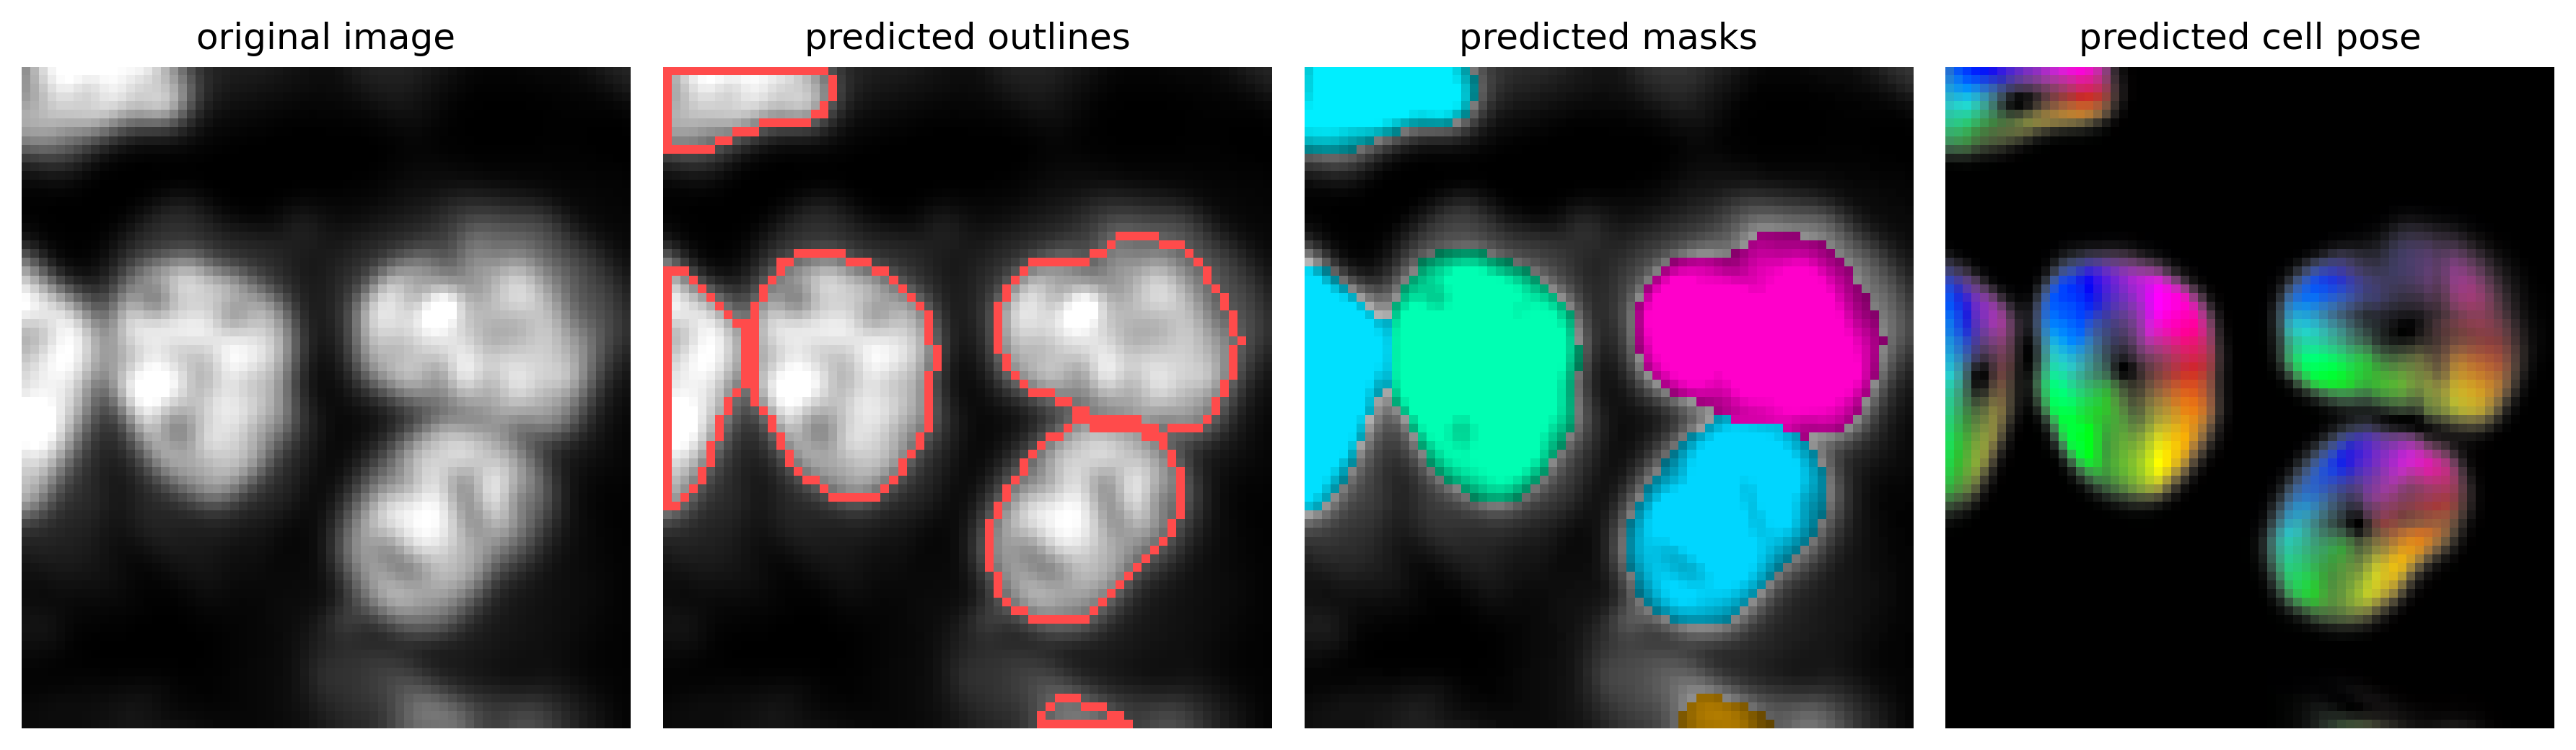

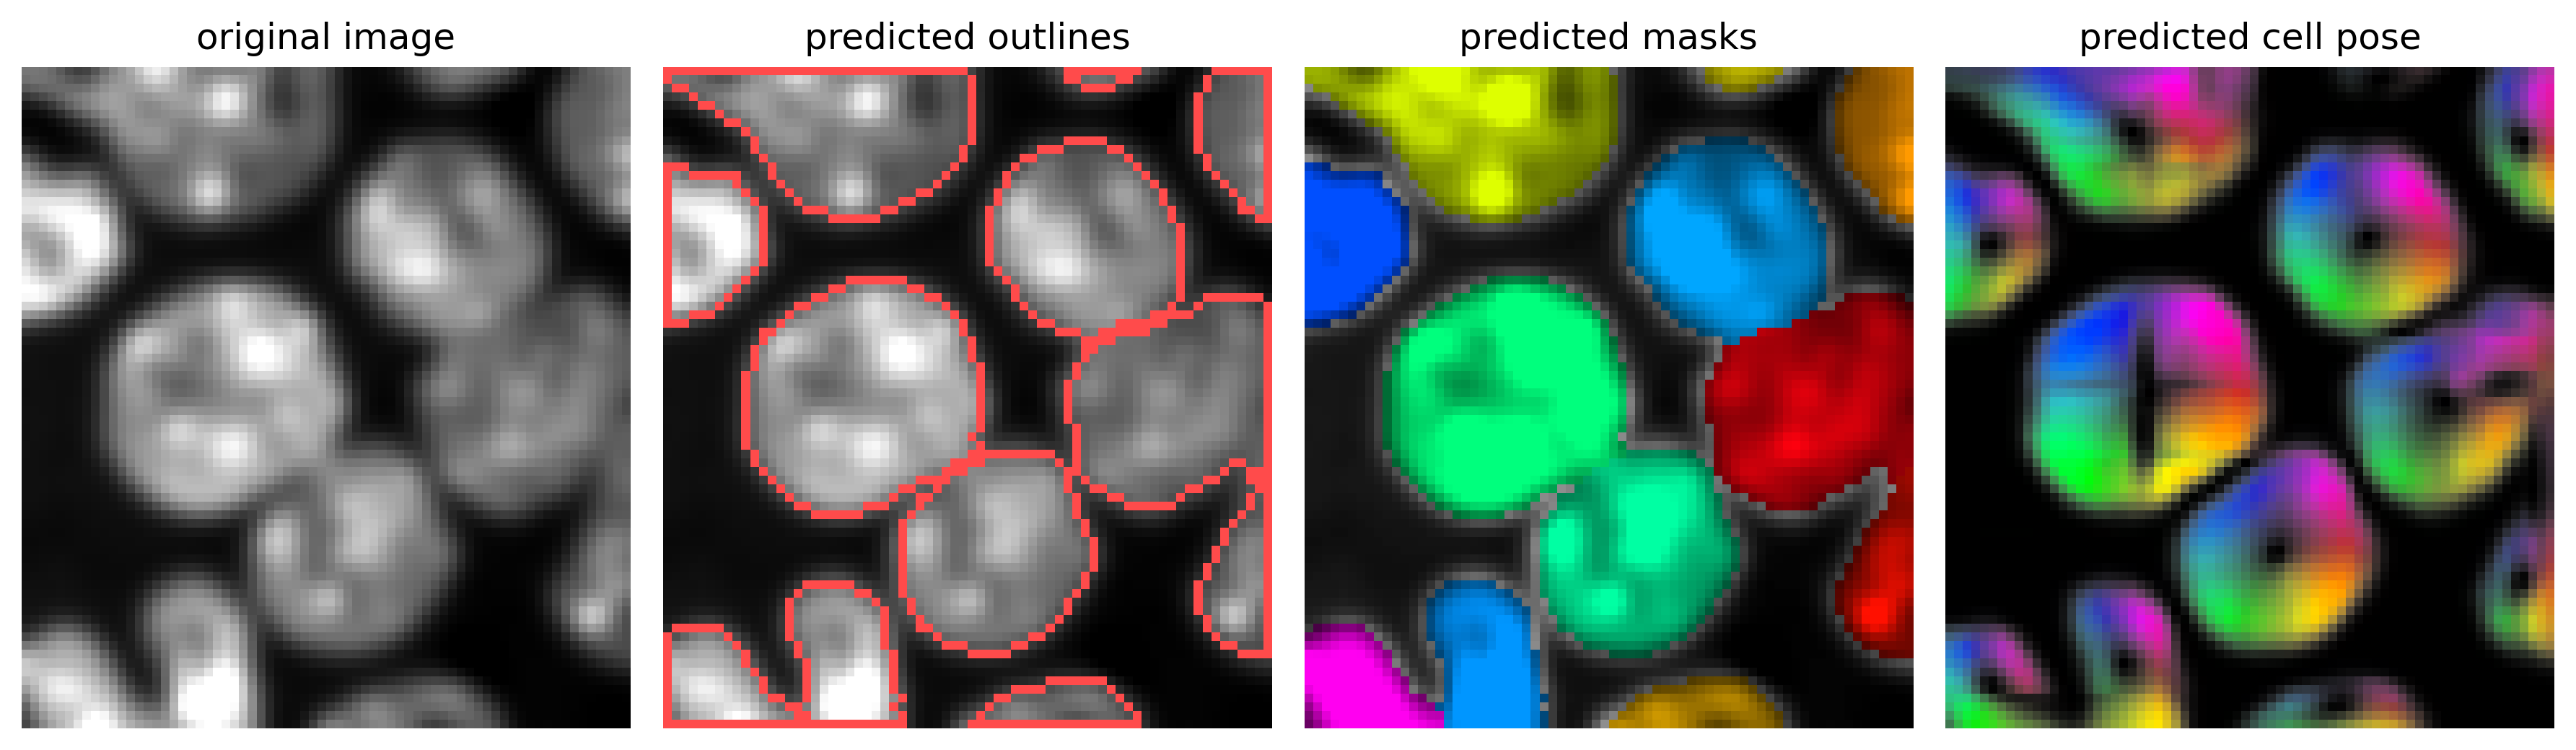

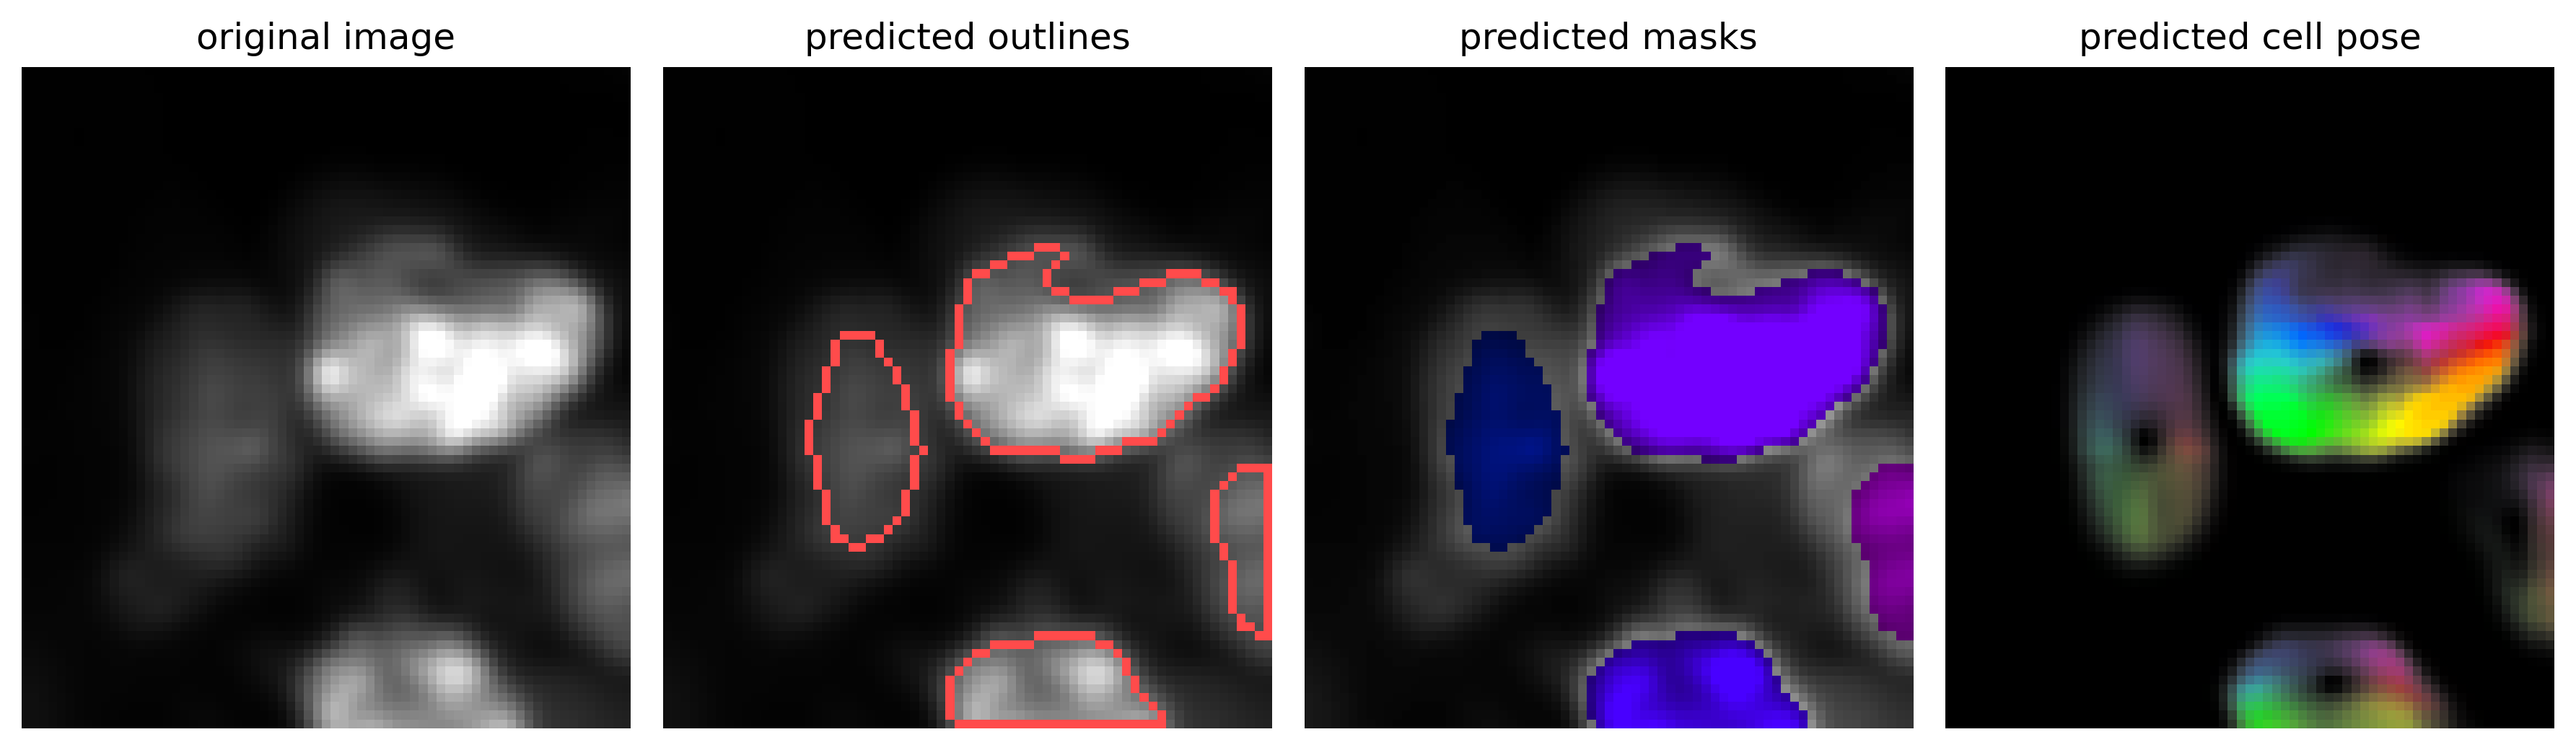

In [3]:
   
# hard-code the paths of our input and output directories
path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

# 解析対象のpositionを選ぶ。ここは要変更
pos_num =("Pos01", "Pos02", "Pos03")


for i in range(len(pos_num)) :
    # ここは変更不要。RNA-seqFISHの最後の、poleA染色時の細胞核の画像。
    nuc_path = os.path.join(path_input, pos_num[i], "ND31_C4_TyR.tif")
    img_nuc = io.imread(nuc_path)
    img_nuc_dim = img_nuc.shape # z, y, xの情報を入れる。
    # 画像によってzの枚数が異なるため、Zの中央に相当する番号をmed_zとして決めておく。
    med_z = round(img_nuc_dim[0]/2)
    
    
    # サイズを1/5に圧縮。Cellposeでうまくsegmentationするために必要。1/5以外だとうまくいかない
    resized_y = round(img_nuc_dim[1]/5)
    resized_x = round(img_nuc_dim[2]/5)

    
    resized_img = resize(img_nuc,
                               output_shape = (img_nuc_dim[0], resized_y, resized_x), # タプルである必要がある。
                               order=1,
                               mode="reflect",
                               preserve_range=True,
                               anti_aliasing=False)

    # 画像をさらに1.5 pixelのgauss blueでぼかす。これもcellposeでのsegmentationをうまく行かせるための操作
    
    blurred = cle.gaussian_blur(resized_img, sigma_x=1.5, sigma_y=1.5, sigma_z=0)
    blurred_round = np.round(blurred)
    

    # RUN CELLPOSE

    # DEFINE CELLPOSE MODEL
    # model_type='cyto' or model_type='nuclei'
    model = models.Cellpose(gpu=False, model_type='nuclei')

    # define CHANNELS to run segementation on
    # grayscale=0, R=1, G=2, B=3
    # channels = [cytoplasm, nucleus]
    # if NUCLEUS channel does not exist, set the second channel to 0
    # channels = [0,0]
    # IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
    # channels = [0,0] # IF YOU HAVE GRAYSCALE
    # channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
    # channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

    # or if you have different types of channels in each image
    channels = [1,0] # 細胞質が赤、核が青

    # if diameter is set to None, the size of the cells is estimated on a per image basis
    # you can set the average cell `diameter` in pixels yourself (recommended) 
    # diameter can be a list or a single number for all images

    # you can run all in a list e.g.
    # imgs = [io.imread(filename) in for filename in files]
    masks, flows, styles, diams = model.eval(blurred_round, diameter= 25, channels=channels, do_3D=True, 
                                             cellprob_threshold=0.0, flow_threshold=0.4,
                                            resample = False, net_avg=False) # diameterを設定しないとうまくいかなかった。
    # io.masks_flows_to_seg(img, masks, flows, diams, files, channels)


    # DISPLAY RESULTS
    # from cellpose import plot
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, blurred_round[med_z,:,:], masks[med_z,:,:], flows[0][med_z,:,:,:], channels=[0,0])
    plt.tight_layout()
    path_output = os.path.join(dir, "1_processed_images", "4_segmentation")
    path = os.path.join(path_output, pos_num[i], "01_nuc_seg_first_round_for_check.png")
    plt.savefig(path)
    
    image_to_process = resize(masks,
                           output_shape = (img_nuc_dim[0], img_nuc_dim[1], img_nuc_dim[2]), # タプルである必要がある。
                           order=None,
                           mode="constant",
                           preserve_range=True,
                           anti_aliasing=False)
    
    

    # https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/basics/select_GPU.py

    import pyclesperanto_prototype as cle

    # list names of all available OpenCL-devices
    print("Available OpenCL devices:" + str(cle.available_device_names()))

    # list CPUs and GPUs separately

    gpu_devices = cle.available_device_names(dev_type="gpu")
    print("Available GPU OpenCL devices:" + str(gpu_devices))

    cpu_devices = cle.available_device_names(dev_type="cpu")
    print("Available CPU OpenCL devices:" + str(cpu_devices))
    
    # https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/basics/count_blobs.ipynb
    import pyclesperanto_prototype as cle

    from skimage.io import imread, imsave, imshow
    import matplotlib
    import numpy as np

    # initialize GPU
    cle.select_device(gpu_devices[0])
        
    
    # load data
    image = image_to_process.astype(np.uint32)
    print("Loaded image size: " + str(image.shape))

    # push image to GPU memory
    input = cle.push(image)
    print("Image size in GPU: " + str(input.shape))
    
    
    input.dtype

    # show result
#     cle.imshow(input[30,:,:], labels=True)
    erode = input
    cle.erode_labels(labels_input = input,
                    labels_destination = erode,
                    radius = 1,
                    relabel_islands = False)
    dilate = input
    cle.dilate_labels(erode,dilate,2)
    open_1 = input
    cle.opening_labels(dilate,open_1,8)
    dilate_2 = input
    cle.dilate_labels(open_1,dilate_2,4)

    # show result
#     cle.imshow(dilate_2[30,:,:], labels=True)


    # データをtiffとして吐き出す。これをimportすれば、segmentationに利用できる。
    path_output = os.path.join(dir, "1_processed_images", "4_segmentation")
    path = os.path.join(path_output, pos_num[i], "01_nuc_seg_first_round.tif")
    imwrite(path, dilate_2.astype(np.uint16))





実行前に以下を修正する必要がある。
pos_numは"Pos01"などと、撮影視野番号を入れる。

上記の設定が終われば、以下を実行する。
Napariが開くため、

In [9]:
# 解析対象のpositionを選ぶ。ここは要変更
pos_N = 1
target_nuc = "ND31_C4_TyR.tif"

import os
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300 #要変更？ https://analytics-note.xyz/programming/matplotlib-figsize-dpi/
from cellpose import utils, io

import numpy as np
from scipy import ndimage as ndi
import napari
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import tifffile

pos_num = f"Pos{pos_N:02d}"
path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")
path_output = os.path.join(dir, "1_processed_images", "4_segmentation")


# ここは変更不要。RNA-seqFISHの最後の、poleA染色時の細胞核の画像。
nuc_path = os.path.join(path_input, pos_num, target_nuc)
nuclei = io.imread(nuc_path)

path = os.path.join(path_output, pos_num, "01_nuc_seg_first_round.tif")
nuc_seg = tifffile.imread(path)
# membranes = tifffile.imread('../images/cells_membrane.tif')


viewer = napari.view_image(
    nuclei,
#     contrast_limits=[0, 1],
    ndisplay=2,
)


from skimage import filters


edges = filters.scharr(nuclei)

nuclei_layer = viewer.layers['nuclei']
nuclei_layer.blending = 'additive'
nuclei_layer.colormap = 'green'

viewer.add_image(
    edges,
    blending='additive',
    colormap='magenta',
    opacity=0.5,
    contrast_limits=(0.0,0.04)
)


path = os.path.join(path_output, pos_num, "DNAseqFIS_foci_enhance_stack.tif")

seqFISH = tifffile.imread(path)
# membranes = tifffile.imread('../images/cells_membrane.tif')

viewer.add_image(
    seqFISH,
    blending='additive',
    colormap='blue',
    gamma=2.0,
    contrast_limits=(0.0,1594.0)
)

labels_layer = viewer.add_labels(nuc_seg.astype(int), 
                                 name='nuc_seg',
                                opacity=0.5)




/Users/HiroshiOchiai/opt/anaconda3/envs/cellpose_napari/lib/python3.8/site-packages/napari_tools_menu/__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Napariでの修正が終わったら以下を実行する。
修正したデータが取り込まれ、データが保存される。

In [10]:
# napariの中で、細胞核に相当するlabelのデータを取得する。pythonでは数値が0から始まるため、
# 細胞核が4番目に来ているはず。
nuc_seg2 = viewer.layers[3].data

# データをtiffとして吐き出す。これをimportすれば、segmentationに利用できる。
from tifffile import imwrite

path = os.path.join(path_output, pos_num, "02_nuc_seg_human_corrected.tif")
imwrite(path, nuc_seg2.astype(np.uint16))
